<a href="https://colab.research.google.com/github/rogerioag/tutorial-de-compiladores/blob/master/tppcompiler/02-compiladores-analise-sintatica-tppparser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/rogerioag/tutorial-de-compiladores/blob/master/tppcompiler/02-compiladores-analise-sintatica-tppparser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Sintática

## Gramática da Linguagem `TPP`
* [Usando Símbolos](https://docs.google.com/document/d/1oYX-5ipzL_izj_hO8s7axuo2OyA279YEhnAItgXzXAQ/edit?usp=sharing)
* [Usando Tokens](https://docs.google.com/document/d/1e7_M-bD1RUbJAnyR8rZyJ35vKbYEN6KQG4l5L8FQ7_I/edit?usp=sharing)

# Preparação do Ambiente

*   Instalação do [PLY](https://www.dabeaz.com/ply/ply.html)


In [ ]:
!pip install ply
!pip install anytree

     |████████████████████████████████| 51kB 1.8MB/s 


In [ ]:
!wget https://raw.githubusercontent.com/rogerioag/tutorial-de-compiladores/master/tppcompiler/tpplex.py
!wget https://raw.githubusercontent.com/rogerioag/tutorial-de-compiladores/master/tppcompiler/mytree.py

--2020-10-23 22:43:44--  https://raw.githubusercontent.com/rogerioag/tutorial-de-compiladores/master/tppcompiler/tpplex.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4364 (4.3K) [text/plain]
Saving to: ‘tpplex.py.1’

tpplex.py.1         100%[===================>]   4.26K  --.-KB/s    in 0s      

2020-10-23 22:43:44 (38.7 MB/s) - ‘tpplex.py.1’ saved [4364/4364]

--2020-10-23 22:43:44--  https://raw.githubusercontent.com/rogerioag/tutorial-de-compiladores/master/tppcompiler/mytree.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1939 

In [ ]:
!ls
!rm tpplex.*
!ls

log-parser.txt	sample_data
rm: cannot remove 'tpplex.*': No such file or directory
log-parser.txt	sample_data


In [ ]:
from sys import argv, exit

import logging

logging.basicConfig(
     level = logging.DEBUG,
     filename = "log-parser.txt",
     filemode = "w",
     format = "%(filename)10s:%(lineno)4d:%(message)s"
)
log = logging.getLogger()

In [ ]:
import ply.yacc as yacc
 
# Get the token map from the lexer.  This is required.
from tpplex import tokens,log

from mytree import MyNode
from anytree.exporter import DotExporter, UniqueDotExporter
from anytree import RenderTree, AsciiStyle

In [ ]:
# Sub-árvore.
#       (programa)
#           |
#   (lista_declaracoes)
#     /     |      \
#   ...    ...     ...
def p_programa(p):
    "programa : lista_declaracoes"

    global root

    programa = MyNode(name='programa', type='PROGRAMA')
    
    root = programa
    p[0] = programa
    p[1].parent = programa

#    (lista_declaracoes)                          (lista_declaracoes)
#          /           \                                    |
# (lista_declaracoes)  (declaracao)                    (declaracao)

def p_lista_declaracoes(p):
    """lista_declaracoes : lista_declaracoes declaracao
                        | declaracao
    """
    pai = MyNode(name='lista_declaracoes', type='LISTA_DECLARACOES')
    p[0] = pai
    p[1].parent = pai

    if len(p) > 2:
        p[2].parent = pai

# Sub-árvore.
#      (declaracao)
#           |
#  (declaracao_variaveis ou  
#   inicializacao_variaveis ou 
#   declaracao_funcao)
def p_declaracao(p):
    """declaracao : declaracao_variaveis
                | inicializacao_variaveis
                | declaracao_funcao
    """
    pai = MyNode(name='declaracao', type='DECLARACAO')
    p[0] = pai
    p[1].parent = pai

# Sub-árvore.
#      (declaracao_variaveis)
#      / p[1]    |           \
# (tipo)    (DOIS_PONTOS)    (lista_variaveis)
#                |
#               (:)
def p_declaracao_variaveis(p):
    "declaracao_variaveis : tipo DOIS_PONTOS lista_variaveis"
    
    pai = MyNode(name='declaracao_variaveis', type='DECLARACAO_VARIAVEIS')
    p[0] = pai

    p[1].parent = pai

    filho = MyNode(name='dois_pontos', type='DOIS_PONTOS', parent=pai)
    filho_sym = MyNode(name=p[2], type='SIMBOLO', parent=filho)
    p[2] = filho
    
    p[3].parent = pai

# Sub-árvore.
#   (inicializacao_variaveis)
#              |
#         (atribuicao)
def p_inicializacao_variaveis(p):
    "inicializacao_variaveis : atribuicao"

    pai = MyNode(name='inicializacao_variaveis', type='INICIALIZACAO_VARIAVEIS')
    p[0] = pai
    p[1].parent = pai

def p_lista_variaveis(p):
    """lista_variaveis : lista_variaveis VIRGULA var
                        | var
    """
    pai = MyNode(name='lista_variaveis', type='LISTA_VARIAVEIS')
    p[0] = pai
    if len(p) > 2:
        p[1].parent = pai
        filho = MyNode(name='virgula', type='VIRGULA', parent=pai)
        filho_sym = MyNode(name=',', type='SIMBOLO', parent=filho)
        p[3].parent = pai
    else:
       p[1].parent = pai 

def p_var(p):
    """var : ID
            | ID indice
    """

    pai = MyNode(name='var', type='VAR')
    p[0] = pai
    filho = MyNode(name='ID', type='ID', parent=pai)
    filho_id = MyNode(name=p[1], type='ID', parent=filho)
    p[1] = filho
    if len(p) > 2:
        p[2].parent = pai

def p_indice(p):
    """indice : indice ABRE_COL expressao FECHA_COL
                | ABRE_COL expressao FECHA_COL
    """
    pai = MyNode(name='indice', type='INDICE')
    p[0] = pai    
    if len(p) == 5:
        p[1].parent = pai   # indice

        filho2 = MyNode(name='abre_col', type='ABRE_COL', parent=pai)
        filho_sym2 = MyNode(name=p[2], type='SIMBOLO', parent=filho2)
        p[2] = filho2
        
        p[3].parent = pai # expressao

        filho4 = MyNode(name='fecha_col', type='FECHA_COL', parent=pai)
        filho_sym4 = MyNode(name=p[4], type='SIMBOLO', parent=filho4)
        p[4] = filho4
    else:
        filho1 = MyNode(name='abre_col', type='ABRE_COL', parent=pai)
        filho_sym1 = MyNode(name=p[1], type='SIMBOLO', parent=filho1)
        p[1] = filho1

        p[2].parent = pai # expressao

        filho3 = MyNode(name='fecha_col', type='FECHA_COL', parent=pai)
        filho_sym3 = MyNode(name=p[3], type='SIMBOLO', parent=filho3)
        p[3] = filho3


def p_indice_error(p):
    """indice : error ABRE_COL expressao FECHA_COL
                | indice ABRE_COL error FECHA_COL
                | ABRE_COL error FECHA_COL
    """

    print("Erro na definicao do indice. Expressao ou indice.")
    
    print("Erro:p[0]:{p0}, p[1]:{p1}, p[2]:{p2}, p[3]:{p3}".format(p0=p[0],p1=p[1],p2=p[2],p3=p[3]))
    error_line = p.lineno(2)
    father = MyNode(name='ERROR::{}'.format(error_line), type='ERROR')
    logging.error(
        "Syntax error parsing index rule at line {}".format(error_line))
    parser.errok()
    p[0] = father
    # if len(p) == 4:
    #     p[1] = new_node('ABRECOLCHETES', father)
    #     p[2].parent = father
    #     p[3] = new_node('FECHACOLCHETES', father)
    # else:
    #     p[1].parent = father
    #     p[2] = new_node('ABRECOLCHETES', father)
    #     p[3].parent = father
    #     p[4] = new_node('FECHACOLCHETES', father)
 

# Sub-árvore:
#    (tipo)
#      |
#  (FLUTUANTE)
def p_tipo(p):
    """tipo : INTEIRO
        | FLUTUANTE
    """

    pai = MyNode(name='tipo', type='TIPO')
    p[0] = pai
    # p[1] = MyNode(name=p[1], type=p[1].upper(), parent=pai)

    if p[1] == "inteiro":
        filho1 = MyNode(name='INTEIRO', type='INTEIRO', parent=pai)
        filho_sym = MyNode(name=p[1], type=p[1].upper(), parent=filho1)
        p[1] = filho1
    else :
        filho1 = MyNode(name='FLUTUANTE', type='FLUTUANTE', parent=pai)
        filho_sym = MyNode(name=p[1], type=p[1].upper(), parent=filho1)


def p_declaracao_funcao(p):
    """declaracao_funcao : tipo cabecalho 
                        | cabecalho 
    """
    pai = MyNode(name='declaracao_funcao', type='DECLARACAO_FUNCAO')
    p[0] = pai
    p[1].parent = pai

    if len(p) == 3:
        p[2].parent = pai

def p_cabecalho_error(p):
    """cabecalho : ID error lista_parametros FECHA_PAR corpo FIM
                | ID ABRE_PAR lista_parametros error corpo FIM
                | ID ABRE_PAR lista_parametros FECHA_PAR corpo 
    """

def p_cabecalho(p):
    "cabecalho : ID ABRE_PAR lista_parametros FECHA_PAR corpo FIM"

    pai = MyNode(name='cabecalho', type='CABECALHO')
    p[0] = pai    
    
    filho1 = MyNode(name='id', type='ID', parent=pai)
    filho_id = MyNode(name=p[1], type='ID', parent=filho1)
    p[1] = filho1

    filho2 = MyNode(name='abre_par', type='ABRE_PAR', parent=pai)
    filho_sym2 = MyNode(name='(', type='SIMBOLO', parent=filho2)
    p[2] = filho2
    
    p[3].parent = pai # lista_parametros

    filho4 = MyNode(name='fecha_par', type='FECHA_PAR', parent=pai)
    filho_sym4 = MyNode(name=')', type='SIMBOLO', parent=filho4)
    p[4] = filho4

    p[5].parent = pai # corpo

    filho6 = MyNode(name='FIM', type='FIM', parent=pai)
    filho_id = MyNode(name='fim', type='FIM', parent=filho6)
    p[6] = filho6


def p_lista_parametros(p):
    """lista_parametros : lista_parametros VIRGULA parametro
                    | parametro
                    | vazio
    """

    pai = MyNode(name='lista_parametros', type='LISTA_PARAMETROS')
    p[0] = pai
    p[1].parent = pai

    if len(p) > 2:
        filho2 = MyNode(name='virgula', type='VIRGULA', parent=pai)
        filho_sym2 = MyNode(name=',', type='SIMBOLO', parent=filho2)
        p[2] = filho2
        p[3].parent = pai

def p_parametro(p):
    """parametro : tipo DOIS_PONTOS ID
                | parametro ABRE_COL FECHA_COL
    """

    pai = MyNode(name='parametro', type='PARAMETRO')
    p[0] = pai
    p[1].parent = pai

    if p[2] == ':':
        filho2 = MyNode(name='dois_pontos', type='DOIS_PONTOS', parent=pai)
        filho_sym2 = MyNode(name=':', type='SIMBOLO', parent=filho2)
        p[2] = filho2

        filho3 = MyNode(name='id', type='ID', parent=pai)
        filho_id = MyNode(name=p[3], type='ID', parent=filho3)        
    else:
        filho2 = MyNode(name='abre_col', type='ABRE_COL', parent=pai)
        filho_sym2 = MyNode(name='[', type='SIMBOLO', parent=filho2)
        p[2] = filho2

        filho3 = MyNode(name='fecha_col', type='FECHA_COL', parent=pai)
        filho_sym3 = MyNode(name=']', type='SIMBOLO', parent=filho3)
        p[3] = filho3    


def p_parametro_error(p):
    """parametro : tipo error ID
                | error ID
                | parametro error FECHA_COL
                | parametro ABRE_COL error
    """

def p_corpo(p):
    """corpo : corpo acao
            | vazio
    """

    pai = MyNode(name='corpo', type='CORPO')
    p[0] = pai
    p[1].parent = pai

    if len(p) > 2:
        p[2].parent = pai


def p_acao(p):
    """acao : expressao
        | declaracao_variaveis
        | se
        | repita
        | leia
        | escreva
        | retorna
    """
    pai = MyNode(name='acao', type='ACAO')
    p[0] = pai
    p[1].parent = pai


def p_se_error(p):
    """se : error expressao ENTAO corpo FIM
        | SE expressao error corpo FIM
        | error expressao ENTAO corpo SENAO corpo FIM
        | SE expressao error corpo SENAO corpo FIM
        | SE expressao ENTAO corpo error corpo FIM
        | SE expressao ENTAO corpo SENAO corpo
    """
    
# Sub-árvore:
#       ________ (se) ________________________________
#      /    /          \      \         \      \      \
# (SE) (expressao)  (ENTAO)  (corpo) (SENAO) (corpo) (FIM)
#  |       |           |
# (se)   (...)      (então) ....
              
def p_se(p):
    """se : SE expressao ENTAO corpo FIM
        | SE expressao ENTAO corpo SENAO corpo FIM
    """

    pai = MyNode(name='se', type='SE')
    p[0] = pai

    filho1 = MyNode(name='SE', type='SE', parent=pai)
    filho_se = MyNode(name=p[1], type='SE', parent=filho1)
    p[1] = filho1

    p[2].parent = pai

    filho3 = MyNode(name='ENTAO', type='ENTAO', parent=pai)
    filho_entao = MyNode(name=p[3], type='ENTAO', parent=filho3)
    p[3] = filho3

    p[4].parent = pai

    if len(p) == 8:
        filho5 = MyNode(name='SENAO', type='SENAO', parent=pai)
        filho_senao = MyNode(name=p[5], type='SENAO', parent=filho5)
        p[5] = filho5

        p[6].parent = pai

        filho7 = MyNode(name='FIM', type='FIM', parent=pai)
        filho_fim = MyNode(name=p[7], type='FIM', parent=filho7)
        p[7] = filho7
    else:
        filho5 = MyNode(name='fim', type='FIM', parent=pai)
        filho_fim = MyNode(name=p[5], type='FIM', parent=filho5)
        p[5]=filho5

             
def p_repita(p):
    "repita : REPITA corpo ATE expressao"

    pai = MyNode(name='repita', type='REPITA')
    p[0] = pai

    filho1 = MyNode(name='REPITA', type='REPITA', parent=pai)
    filho_repita = MyNode(name=p[1], type='REPITA', parent=filho1)
    p[1] = filho1

    p[2].parent = pai # corpo.

    filho3 = MyNode(name='ATE', type='ATE', parent=pai)
    filho_ate = MyNode(name=p[1], type='ATE', parent=filho3)
    p[3] = filho3
    
    p[4].parent = pai   # expressao.

def p_repita_error(p):
    """repita : error corpo ATE expressao
            | REPITA corpo error expressao
    """
    

def p_atribuicao(p):
    "atribuicao : var ATRIBUICAO expressao"

    pai = MyNode(name='atribuicao', type='ATRIBUICAO')
    p[0] = pai

    p[1].parent = pai

    filho2 = MyNode(name='ATRIBUICAO', type='ATRIBUICAO', parent=pai)
    filho_sym2 = MyNode(name=':=', type='SIMBOLO', parent=filho2)
    p[2] = filho2
    
    p[3].parent = pai

def p_leia(p):
    "leia : LEIA ABRE_PAR var FECHA_PAR"

    pai = MyNode(name='leia', type='LEIA')
    p[0] = pai

    filho1 = MyNode(name='LEIA', type='LEIA', parent=pai)
    filho_sym1 = MyNode(name=p[1], type='LEIA', parent=filho1)
    p[1] = filho1

    filho2 = MyNode(name='abre_par', type='ABRE_PAR', parent=pai)
    filho_sym2 = MyNode(name='(', type='SIMBOLO', parent=filho2)
    p[2] = filho2
    
    p[3].parent = pai # var

    filho4 = MyNode(name='fecha_par', type='FECHA_PAR', parent=pai)
    filho_sym4 = MyNode(name=')', type='SIMBOLO', parent=filho4)
    p[4] = filho4

def p_leia_error(p):
    """leia : LEIA ABRE_PAR error FECHA_PAR
    """


def p_escreva(p):
    "escreva : ESCREVA ABRE_PAR expressao FECHA_PAR"

    pai = MyNode(name='escreva', type='ESCREVA')
    p[0] = pai

    filho1 = MyNode(name='ESCREVA', type='ESCREVA', parent=pai)
    filho_sym1 = MyNode(name=p[1], type='ESCREVA', parent=filho1)
    p[1] = filho1

    filho2 = MyNode(name='abre_par', type='ABRE_PAR', parent=pai)
    filho_sym2 = MyNode(name='(', type='SIMBOLO', parent=filho2)
    p[2] = filho2
    
    p[3].parent = pai # expressao.

    filho4 = MyNode(name='fecha_par', type='FECHA_PAR', parent=pai)
    filho_sym4 = MyNode(name=')', type='SIMBOLO', parent=filho4)
    p[4] = filho4


def p_retorna(p):
    "retorna : RETORNA ABRE_PAR expressao FECHA_PAR"

    pai = MyNode(name='retorna', type='RETORNA')
    p[0] = pai

    filho1 = MyNode(name='RETORNA', type='RETORNA', parent=pai)
    filho_sym1 = MyNode(name=p[1], type='RETORNA', parent=filho1)
    p[1] = filho1

    filho2 = MyNode(name='abre_par', type='ABRE_PAR', parent=pai)
    filho_sym2 = MyNode(name='(', type='SIMBOLO', parent=filho2)
    p[2] = filho2
    
    p[3].parent = pai # expressao.

    filho4 = MyNode(name='fecha_par', type='FECHA_PAR', parent=pai)
    filho_sym4 = MyNode(name=')', type='SIMBOLO', parent=filho4)
    p[4] = filho4


def p_expressao(p):
    """expressao : expressao_logica
                    | atribuicao
    """
    pai = MyNode(name='expressao', type='EXPRESSAO')
    p[0] = pai
    p[1].parent = pai

def p_expressao_logica(p):
    """expressao_logica : expressao_simples
                    | expressao_logica operador_logico expressao_simples
    """
    pai = MyNode(name='expressao_logica', type='EXPRESSAO_LOGICA')
    p[0] = pai
    p[1].parent = pai

    if len(p) > 2:
        p[2].parent = pai
        p[3].parent = pai

def p_expressao_simples(p):
    """expressao_simples : expressao_aditiva
                        | expressao_simples operador_relacional expressao_aditiva
    """

    pai = MyNode(name='expressao_simples', type='EXPRESSAO_SIMPLES')
    p[0] = pai
    p[1].parent = pai

    if len(p) > 2:
        p[2].parent = pai
        p[3].parent = pai

def p_expressao_aditiva(p):
    """expressao_aditiva : expressao_multiplicativa
                        | expressao_aditiva operador_soma expressao_multiplicativa
    """

    pai = MyNode(name='expressao_aditiva', type='EXPRESSAO_ADITIVA')
    p[0] = pai
    p[1].parent = pai

    if len(p) > 2:
        p[2].parent = pai
        p[3].parent = pai


def p_expressao_multiplicativa(p):
    """expressao_multiplicativa : expressao_unaria
                               | expressao_multiplicativa operador_multiplicacao expressao_unaria
        """

    pai = MyNode(name='expressao_multiplicativa', type='EXPRESSAO_MULTIPLICATIVA')
    p[0] = pai
    p[1].parent = pai

    if len(p) > 2:
        p[2].parent = pai
        p[3].parent = pai


def p_expressao_unaria(p):
    """expressao_unaria : fator
                        | operador_soma fator
                        | operador_negacao fator
        """
    pai = MyNode(name='expressao_unaria', type='EXPRESSAO_UNARIA')
    p[0] = pai
    p[1].parent = pai
    
    if p[1] == '!':
        filho1 = MyNode(name='operador_negacao', type='OPERADOR_NEGACAO', parent=pai)
        filho_sym1 = MyNode(name=p[1], type='SIMBOLO', parent=filho1)
        p[1] = filho1
    else:
        p[1].parent = pai

    if len(p) > 2:
        p[2].parent = pai


def p_operador_relacional(p):
    """operador_relacional : MENOR
                            | MAIOR
                            | IGUALDADE
                            | DIFERENCA 
                            | MENOR_IGUAL
                            | MAIOR_IGUAL
    """
    pai = MyNode(name='operador_soma', type='OPERADOR_SOMA')
    p[0] = pai

    if p[1] == "<":
        filho = MyNode(name='menor', type='MENOR', parent=pai)
        filho_sym = MyNode(name=p[1], type='SIMBOLO', parent=filho)
    elif p[1] == ">":
        filho = MyNode(name='maior', type='MAIOR', parent=pai)
        filho_sym = MyNode(name=p[1], type='SIMBOLO', parent=filho)
    elif p[1] == "=":
        filho = MyNode(name='igual', type='IGUAL', parent=pai)
        filho_sym = MyNode(name=p[1], type='SIMBOLO', parent=filho)
    elif p[1] == "<>":
        filho = MyNode(name='diferenca', type='DIFERENCA', parent=pai)
        filho_sym = MyNode(name=p[1], type='SIMBOLO', parent=filho)
    elif p[1] == "<=":
        filho = MyNode(name='menor_igual', type='MENOR_IGUAL', parent=pai)
        filho_sym = MyNode(name=p[1], type='SIMBOLO', parent=filho)
    elif p[1] == ">=":
        filho = MyNode(name='maior_igual', type='MAIOR_IGUAL', parent=pai)
        filho_sym = MyNode(name=p[1], type='SIMBOLO', parent=filho)
    else:
        print('Erro operador relacional')
    
    p[1] = filho
           

def p_operador_soma(p):
    """operador_soma : ADICAO
                    | SUBTRACAO
    """
    if p[1] == "+":
        adicao = MyNode(name='adicao', type='ADICAO')
        adicao_lexema = MyNode(name='+', type='SIMBOLO', parent=adicao)
        p[0] = MyNode(name='operador_soma', type='OPERADOR_SOMA', children=[adicao])
    else:
       subtracao = MyNode(name='subtracao', type='SUBTRACAO')
       subtracao_lexema = MyNode(name='-', type='SIMBOLO', parent=subtracao)
       p[0] = MyNode(name='operador_soma', type='OPERADOR_SOMA', children=[subtracao])     
   

def p_operador_logico(p):
    """operador_logico : E_LOGICO
                    | OU_LOGICO
    """
    if p[1] == "&&":
        filho = MyNode(name='e_logico', type='E_LOGICO')
        filho_lexema = MyNode(name=p[1], type='SIMBOLO', parent=filho)
        p[0] = MyNode(name='operador_logico', type='OPERADOR_LOGICO', children=[filho])
    else:
        filho = MyNode(name='ou_logico', type='OU_LOGICO')
        filho_lexema = MyNode(name=p[1], type='SIMBOLO', parent=filho)
        p[0] = MyNode(name='operador_logico', type='OPERADOR_SOMA', children=[filho])


def p_operador_negacao(p):
    "operador_negacao : NEGACAO"

    if p[1] == "!":
        filho = MyNode(name='negacao', type='NEGACAO')
        negacao_lexema = MyNode(name=p[1], type='SIMBOLO', parent=filho)
        p[0] = MyNode(name='operador_negacao', type='OPERADOR_NEGACAO', children=[filho])


def p_operador_multiplicacao(p):
    """operador_multiplicacao : MULTIPLICACAO
                            | DIVISAO
        """
    if p[1] == "*":
        filho = MyNode(name='multiplicacao', type='MULTIPLICACAO')
        multiplicacao_lexema = MyNode(name=p[1], type='SIMBOLO', parent=filho)
        p[0] = MyNode(name='operador_multiplicacao', type='OPERADOR_MULTIPLICACAO', children=[filho])
    else:
       divisao = MyNode(name='divisao', type='DIVISAO')
       divisao_lexema = MyNode(name=p[1], type='SIMBOLO', parent=divisao)
       p[0] = MyNode(name='operador_soma', type='OPERADOR_SOMA', children=[divisao])


def p_fator(p):
    """fator : ABRE_PAR expressao FECHA_PAR
            | var
            | chamada_funcao
            | numero
        """
    pai = MyNode(name='fator', type='FATOR')
    p[0] = pai
    if len(p) > 2:
        filho1 = MyNode(name='abre_par', type='ABRE_PAR', parent=pai)
        filho_sym1 = MyNode(name=p[1], type='SIMBOLO', parent=filho1)
        p[1] = filho1

        p[2].parent = pai

        filho3 = MyNode(name='fecha_par', type='FECHA_PAR', parent=pai)
        filho_sym3 = MyNode(name=p[3], type='SIMBOLO', parent=filho3)
        p[3] = filho3
    else:
        p[1].parent = pai


def p_fator_error(p):
    """fator : error ABRE_PAR expressao FECHA_PAR
              | ABRE_PAR error FECHA_PAR
        """
    

def p_numero(p):
    """numero : NUM_INTEIRO
                | NUM_PONTO_FLUTUANTE
                | NUM_NOTACAO_CIENTIFICA
    """

    pai = MyNode(name='numero', type='NUMERO')
    p[0] = pai

    if str(p[1]).find('.') == -1:
        aux = MyNode(name='NUM_INTEIRO', type='NUM_INTEIRO', parent=pai)
        aux_val = MyNode(name=p[1], type='VALOR', parent=aux)
        p[1] = aux
    elif str(p[1]).find('e') >= 0:
        aux = MyNode(name='NUM_NOTACAO_CIENTIFICA', type='NUM_NOTACAO_CIENTIFICA', parent=pai)
        aux_val = MyNode(name=p[1], type='VALOR', parent=aux)
        p[1] = aux
    else:
        aux = MyNode(name='NUM_PONTO_FLUTUANTE', type='NUM_PONTO_FLUTUANTE', parent=pai)
        aux_val = MyNode(name=p[1], type='VALOR', parent=aux)
        p[1] = aux


def p_chamada_funcao(p):
    "chamada_funcao : ID ABRE_PAR lista_argumentos FECHA_PAR"

    pai = MyNode(name='chamada_funcao', type='CHAMADA_FUNCAO')
    p[0] = pai
    if len(p) > 2:
        filho1 = MyNode(name='ID', type='ID', parent=pai)
        filho_id = MyNode(name=p[1], type='ID', parent=filho1)
        p[1] = filho1

        filho2 = MyNode(name='abre_par', type='ABRE_PAR', parent=pai)
        filho_sym = MyNode(name=p[2], type='SIMBOLO', parent=filho2)
        p[2] = filho2

        p[3].parent = pai

        filho4 = MyNode(name='fecha_par', type='FECHA_PAR', parent=pai)
        filho_sym = MyNode(name=p[4], type='SIMBOLO', parent=filho4)
        p[4] = filho4
    else:
        p[1].parent = pai


def p_lista_argumentos(p):
    """lista_argumentos : lista_argumentos VIRGULA expressao
                    | expressao
                    | vazio
        """
    pai = MyNode(name='lista_argumentos', type='LISTA_ARGUMENTOS')
    p[0] = pai

    if len(p) > 2:
        p[1].parent = pai
        
        filho2 = MyNode(name='VIRGULA', type='VIRGULA', parent=pai)
        filho_sym = MyNode(name=p[2], type='SIMBOLO', parent=filho2)
        p[2] = filho2

        p[3].parent = pai
    else:
        p[1].parent = pai

def p_vazio(p):
    "vazio : "

    pai = MyNode(name='vazio', type='VAZIO')
    p[0] = pai

def p_error(p):

    if p:
        token = p
        print("Erro:[{line},{column}]: Erro próximo ao token '{token}'".format(line=token.lineno, column=token.lineno, token=token.value))

In [ ]:
# Programa principal.
def main():
    argv[1] = 'teste.tpp'
    aux = argv[1].split('.')
    if aux[-1] != 'tpp':
      raise IOError("Not a .tpp file!")
    data = open(argv[1])

    source_file = data.read()
    parser.parse(source_file)

    if root and root.children != ():
        print("Generating Syntax Tree Graph...")
        DotExporter(root).to_picture(argv[1] + ".ast.png")
        UniqueDotExporter(root).to_picture(argv[1] + ".unique.ast.png")
        DotExporter(root).to_dotfile(argv[1] + ".ast.dot")
        UniqueDotExporter(root).to_dotfile(argv[1] + ".unique.ast.dot")
        print(RenderTree(root, style=AsciiStyle()).by_attr())
        print("Graph was generated.\nOutput file: " + argv[1] + ".ast.png")

        DotExporter(root, graph="graph",
            nodenamefunc=MyNode.nodenamefunc,
            nodeattrfunc=lambda node: 'label=%s' % (node.type),
            edgeattrfunc=MyNode.edgeattrfunc,
            edgetypefunc=MyNode.edgetypefunc).to_picture(argv[1] + ".ast2.png")


        # DotExporter(root, nodenamefunc=lambda node: node.label).to_picture(argv[1] + ".ast3.png")



    else:
        print("Unable to generate Syntax Tree.")
    print('\n\n')

In [ ]:
# Build the parser.
__file__ = "02-compiladores-analise-sintatica-tppparser.ipynb"
# parser = yacc.yacc(optimize=True, start='programa', debug=True, debuglog=log)
parser =  yacc.yacc(method="LALR", optimize=True, start='programa', debug=True, debuglog=log, write_tables=False, tabmodule='tpp_parser_tab') 

if __name__ == "__main__":
    main()

Generating LALR tables


Generating Syntax Tree Graph...
programa
+-- lista_declaracoes
    |-- lista_declaracoes
    |   |-- lista_declaracoes
    |   |   |-- lista_declaracoes
    |   |   |   |-- lista_declaracoes
    |   |   |   |   +-- declaracao
    |   |   |   |       +-- declaracao_variaveis
    |   |   |   |           |-- tipo
    |   |   |   |           |   +-- INTEIRO
    |   |   |   |           |       +-- inteiro
    |   |   |   |           |-- dois_pontos
    |   |   |   |           |   +-- :
    |   |   |   |           +-- lista_variaveis
    |   |   |   |               +-- var
    |   |   |   |                   |-- ID
    |   |   |   |                   |   +-- a
    |   |   |   |                   +-- indice
    |   |   |   |                       |-- abre_col
    |   |   |   |                       |   +-- [
    |   |   |   |                       |-- expressao
    |   |   |   |                       |   +-- expressao_logica
    |   |   |   |                       |       +-- expressao_simple

In [ ]:
%%writefile teste.tpp

inteiro: a[10]
flutuante: b

inteiro func1(inteiro:x, flutuante:y)
  inteiro: res
  se (x > y) então
    res := x + y
  senão
    res := x * y
  fim
  retorna(res)
fim

func2(inteiro:z, flutuante:w)
  a := z
  b := w
fim

inteiro principal()
  inteiro: x,y
  flutuante: w
  a := 10 + 2
  leia(x)
  leia(w)
  w := .6 + 1.
  func2(1, 2.5)
  b := func1(x,w)
  escreva(b)
  retorna(0)
fim


Writing teste.tpp


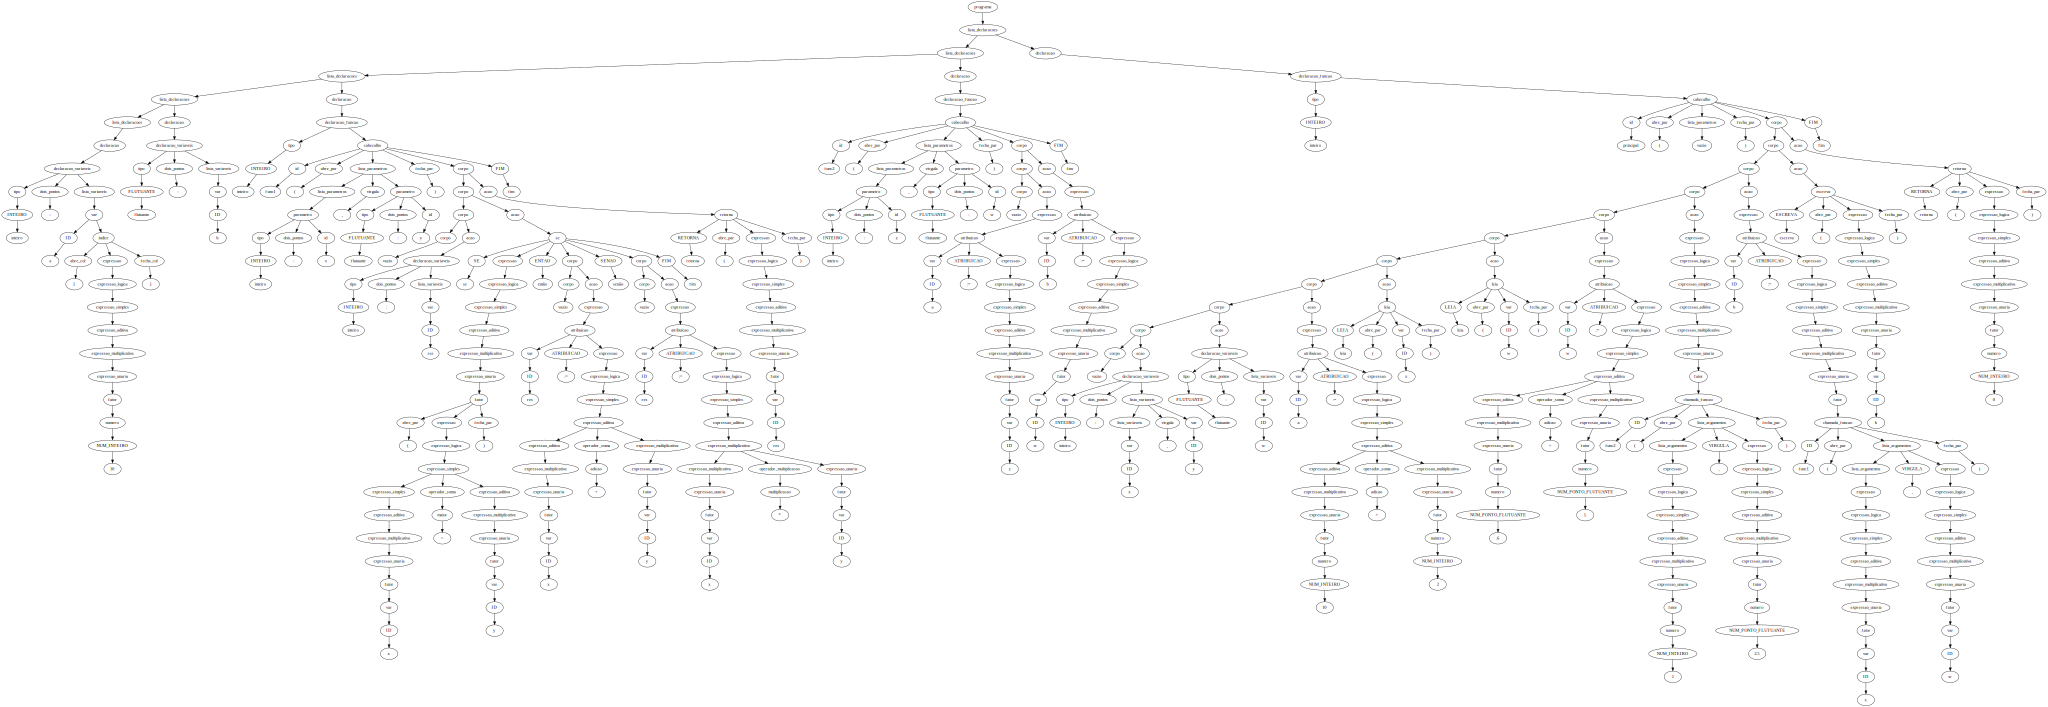

In [ ]:
import graphviz

with open("/content/teste.tpp.unique.ast.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

## Tabela de Símbolos


In [ ]:
symtable = {}



In [ ]:
symtable['a'] = {
        'token': 'ID',
        'lexeme':'a',
        'line': 100,
        'label': 'ID',
        'dimension':1,
        'size_dim_1':1,
        'size_dim_2':0,    
        'id_type': 'ID',
        'declared':'S',
        'initialized': 'S',
        'args': None,
        'type': None,
        'scope': None
    }

In [ ]:
print(symtable['a']['id_type'], symtable['a']['dimension'])

ID 1
